In [1]:
#import jax and other libraries for computation
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util
import jax.random as random
import numpy as np
#for visulization
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
# import AdoptODE
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
#import the MSD mechanics
from HelperAndMechanics import *
import h5py

In [2]:
def list_h5_structure(file_path):
    '''Recursively lists all groups, datasets, and attributes in an HDF5 file'''
    
    def print_structure(name, obj):
        indent = '  ' * name.count('/')
        if isinstance(obj, h5py.Group):
            print(f"{indent}📂 Group: {name}")
            # for key, value in obj.attrs.items():
            #     print(f"{indent}  └── 🏷️  Attribute: {key} = {value}")
        # elif isinstance(obj, h5py.Dataset):
            # print(f"{indent}📄 Dataset: {name} - shape: {obj.shape}, dtype: {obj.dtype}")
    
    with h5py.File(file_path, 'r') as f:
        print(f"📁 HDF5 File: {file_path}")
        f.visititems(print_structure)

def define_MSD_BOCF(**kwargs_sys):
  disc_x, disc_y = kwargs_sys['disc_x'], kwargs_sys['disc_y']
  dx, dy = kwargs_sys['len_x'] / disc_x, kwargs_sys['len_y'] / disc_y
  N_sys = kwargs_sys['N_sys']

  def d_dx(f):
    return jnp.concatenate((jnp.zeros(
        (1, disc_x)), f[1:] - f[:-1], jnp.zeros((1, disc_x))),
                           axis=0)

  def d_dy(f):
    return jnp.concatenate((jnp.zeros(
        (disc_y, 1)), f[:, 1:] - f[:, :-1], jnp.zeros((disc_y, 1))),
                           axis=1)

  def gradient(f):  #gradient of scalar field
    gx = d_dx(f)
    gy = d_dy(f)
    return jnp.stack((gx, gy), axis=2)

  # stencil5 = np.array([1/4,1/2,-1.5,1/2,1/4])
  # distr5 = np.array([0.05,0.1,0.7,0.1,0.05])
  # kernel = np.outer(distr5, stencil5/dz**2) + np.outer(stencil5/dx**2, distr5)
  kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (
      dx * dy * 6)  #np.array([[0,1,0],[1,-4,1.],[0,1,0]])/(dx*dy)

  def laplace(f):  #laplace of scalar
    f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
    f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
    return convolve2d(f_ext, kernel, mode='valid')

  H = lambda x: jnp.heaviside(x, 0)

  missing_params = {}
  for key in kwargs_sys.keys():
    if not key in [
        'disc_x', 'disc_y', 'len_x', 'len_y', 'N_sys', 'Params_BOCF',
        'puls_amp', 'puls_size', 'puls_reps', 'puls_dist', 'puls_num'
    ] + kwargs_sys['Params_BOCF']:
      missing_params[key] = kwargs_sys[key]

  def tau_v_minus(u, ap):
    return (1 - H(u - ap['theta_v_minus'])) * ap['tau_v_minus1'] + H(
        u - ap['theta_v_minus']) * ap['tau_v_minus2']

  def tau_w_minus(u, ap):
    return ap['tau_w_minus1'] + (ap['tau_w_minus2'] - ap['tau_w_minus1']) * (
        1 + jnp.tanh(ap['k_w_minus'] * (u - ap['u_w_minus']))) / 2

  def tau_so(u, ap):
    return ap['tau_so1'] + (ap['tau_so2'] - ap['tau_so1']) * (
        1 + jnp.tanh(ap['k_so'] * (u - ap['u_so']))) / 2

  def tau_s(u, ap):
    return (1 - H(u - ap['theta_w'])
            ) * ap['tau_s1'] + H(u - ap['theta_w']) * ap['tau_s2']

  def tau_o(u, ap):
    return (1 - H(u - ap['theta_o'])
            ) * ap['tau_o1'] + H(u - ap['theta_o']) * ap['tau_o2']

  def v_inf(u, ap):
    return (1 - H(u - ap['theta_v_minus']))

  def w_inf(u, ap):
    return (1 - H(u - ap['theta_o'])) * (
        1 - u / ap['tau_w_inf']) + H(u - ap['theta_o']) * ap['w_inf_star']

  # D = kwargs_sys['D']
  u0, v0, w0, s0 = kwargs_sys['u0'], kwargs_sys['v0'], kwargs_sys[
      'w0'], kwargs_sys['s0']
  puls_amp, puls_size, puls_num, puls_dist, puls_reps = kwargs_sys[
      'puls_amp'], kwargs_sys['puls_size'], kwargs_sys['puls_num'], kwargs_sys[
          'puls_dist'], kwargs_sys['puls_reps']

  def J_fi(y, ap):
    return -(y['v'] * H(y['u'] - ap['theta_v']) * (y['u'] - ap['theta_v']) *
             (ap['u_u'] - y['u'])) / ap['tau_fi']

  def J_so(y, ap):
    return (y['u'] - ap['u_o']) * (1 - H(y['u'] - ap['theta_w'])) / tau_o(
        y['u'], ap) + H(y['u'] - ap['theta_w']) / tau_so(y['u'], ap)

  def J_si(y, ap):
    return -H(y['u'] - ap['theta_w']) * y['w'] * y['s'] / ap['tau_si']

  def du_dt(y, ap):
    return ap['D'] * laplace(y['u']) - (J_fi(y, ap) + J_so(y, ap) +
                                        J_si(y, ap))

  def dv_dt(y, ap):
    return (1 - H(y['u'] - ap['theta_v'])) * (
        v_inf(y['u'], ap) - y['v']) / tau_v_minus(
            y['u'], ap) - H(y['u'] - ap['theta_v']) * y['v'] / ap['tau_v_plus']

  def dw_dt(y, ap):
    return (1 - H(y['u'] - ap['theta_w'])) * (
        w_inf(y['u'], ap) - y['w']) / tau_w_minus(
            y['u'], ap) - H(y['u'] - ap['theta_w']) * y['w'] / ap['tau_w_plus']

  def ds_dt(y, ap):
    return (
        (1 + jnp.tanh(ap['k_s'] *
                      (y['u'] - ap['u_s']))) / 2 - y['s']) / tau_s(y['u'], ap)
                      
  def rescale_params(params):
    params_scaled = {}
    
    for key in params.keys():
        if key in kwargs_sys['Params_BOCF']:
            if kwargs_sys[key]<1:
                params_scaled[key] = params[key]
            else:
                params_scaled[key] = 10**params[key]
        
    return params_scaled
  #for MSD	   
  @jit
  def epsilon_T(u):
    return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
  @jit
  def eom(y, t, params, iparams, exparams):
    all_params = {**rescale_params(params), **missing_params}
    dudt = du_dt(y, all_params)
    dvdt = dv_dt(y, all_params)
    dwdt = dw_dt(y, all_params)
    dsdt = ds_dt(y, all_params)
    dTdt = 1/12.9*epsilon_T(y['u']/1.5)*(params['k_T']*jnp.abs(y['u']/1.5)-y['T'])
    dx_dotdt = 1/12.9*1/params['m'] *  (force_field_active(y['x'],y['T'],params) + force_field_passive(y['x'],params) + force_field_struct(y['x'],y['T'],params) - y['x_dot'] * params['c_damp'])
    dxdt = 1/12.9*y['x_dot']
    return {'u': dudt, 'v': dvdt, 'w': dwdt, 's': dsdt,'T':dTdt,'x':dxdt,'x_dot':dx_dotdt}

  @jit
  def loss(ys, params, iparams, exparams, targets):
    flat_fit = ravel_pytree(ys)[0]
    flat_target = ravel_pytree(targets)[0]
    return jnp.nanmean((flat_fit - flat_target)**2)

  def gen_params():
    params = {}
    for key in kwargs_sys['Params_BOCF']:
      if kwargs_sys[key]<1:
        params[key] = kwargs_sys[key] * (0.5 + np.random.rand())
      else:
        params[key] = np.log10(kwargs_sys[key] * (0.5 + np.random.rand()))
    for key in kwargs_sys['Params_MSD']:
      params[key] = kwargs_sys[key] 
    return params, {}, {}

  def gen_y0():
    u = u0 * jnp.ones((disc_x, disc_y))
    v = v0 * jnp.ones((disc_x, disc_y))
    w = w0 * jnp.ones((disc_x, disc_y))
    s = s0 * jnp.ones((disc_x, disc_y))
    #initialize the mechanical part
    size_mech = disc_x + 2* kwargs_sys['pad'] + 1
    x_vals = np.linspace(0, size_mech-1,size_mech)
    z_vals = np.linspace(0, size_mech-1,size_mech)
    # Generate meshgrid for x and z
    x_grid, z_grid = np.meshgrid(x_vals, z_vals)
    xy_grid = jnp.array([x_grid, z_grid])
    
    y = {'u': u, 'v': v, 'w': w, 's': s,'T':jnp.zeros((disc_x, disc_y)),'x':xy_grid,'x_dot':jnp.zeros(xy_grid.shape)}
    params_true = {}
    for key in kwargs_sys['Params_BOCF']:
      if kwargs_sys[key]<1:
        params_true[key] = kwargs_sys[key]
      else:
        params_true[key] = np.log10(kwargs_sys[key])
    for key in kwargs_sys['Params_MSD']:
      params_true[key] = kwargs_sys[key] 

    solver = jit(lambda y: odeint(eom,
                                  y,
                                  np.array([0.0, puls_dist]),
                                  params_true, {}, {},
                                  atol=1e-4,
                                  rtol=1e-4))
    for i in range(puls_reps):
      mask = np.zeros((disc_x, disc_y))
      pos = np.round(
          np.random.rand(puls_num, 2) *
          np.array([disc_x - puls_size - 1, disc_y - puls_size - 1
                    ])[np.newaxis]).astype(int)
      for p in pos:
        mask[p[0]:p[0] + puls_size,
             p[1]:p[1] + puls_size] = puls_amp * np.ones(
                 (puls_size, puls_size))
      y['u'] = y['u'] + mask
      sol = solver(y)
      y = tree_util.tree_map(lambda x: x[-1], sol)
    return y

  return eom, loss, gen_params, gen_y0, {}

In [3]:
domain_size = 128

In [4]:
# Defining standard parameters:
# This is a smaller system with adjusted parameters to allow spiral wave to occure in the smaller simulation domain.
# For the full code with larger simulation domain is at the end of this notebook.

kwargs_sys = {
    'disc_x': domain_size,#512
    'disc_y': domain_size,#512
    'len_x': domain_size,
    'len_y': domain_size,
    'N_sys': 1,
    'u_o': 0,
    'u_u': 1.58,
    'theta_v': 0.3,
    'theta_w': 0.015,
    'theta_v_minus': 0.015,
    'theta_o': 0.006,
    'tau_v_minus1': 60,
    'tau_v_minus2': 1150,
    'tau_v_plus': 1.4506,
    'tau_w_minus1': 70,
    'tau_w_minus2': 20,
    'k_w_minus': 65,
    'u_w_minus': 0.03,
    'tau_w_plus': 280,
    'tau_fi': 0.11,
    'tau_o1': 6,
    'tau_o2': 6,
    'tau_so1': 43,
    'tau_so2': 0.2,
    'k_so': 2,
    'u_so': 0.65,
    'tau_s1': 2.7342,
    'tau_s2': 3,
    'k_s': 2.0994,
    'u_s': 0.9087,
    'tau_si': 2.8723,
    'tau_w_inf': 0.07,
    'w_inf_star': 0.94,
    'u0': 0,
    'v0': 1,
    'w0': 1,
    's0': 0,
    'D': 0.1,
    'Params_BOCF': ['u_s', 'u_so', 'k_so', 'tau_so1', 'tau_si', 'k_s', 'u_u', 'theta_v', 'D', 'tau_fi'], # These are the Parameters forgotten and recovered by training!
    'Params_MSD': ['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing'],
    'pad':10,
    'puls_amp': 1.0,   #
    'puls_size': 3,    #
    'puls_reps': 30,   # These numbers define the initialization procedure
    'puls_dist': 150,  #
    'puls_num': 20     #
}
keys_MSD =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing']
N,size,params_true_MSD = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing'],mode = 'chaos')
params_true_MSD = dict(zip(keys_MSD,params_true_MSD))

for key in params_true_MSD.keys():
    kwargs_sys[key] = params_true_MSD[key]

In [5]:
# Following lines set up parameters and boundaries according to the parameters selected for training with 'Params_BOCF'
params_true = {}
lower_bound = {}
for key in kwargs_sys['Params_BOCF']:
  if kwargs_sys[key]<1:
    params_true[key] = kwargs_sys[key]
    lower_bound[key] = 0
  else:
    lower_bound[key] = -2
    params_true[key] = np.log10(kwargs_sys[key])
for key in kwargs_sys['Params_MSD']:
  params_true[key] = params_true_MSD[key]
  lower_bound[key] = 0

print(params_true)
# Setting up simulation domain
N_times = 100
t_evals = jnp.linspace(0, 50, N_times)

# Specifying training properties
reset_every = 34
t_reset_idcs = tuple([
    reset_every * i
    for i in range(int(np.ceil((len(t_evals) - 1) / reset_every)))
])
kwargs_adoptODE = {
  
    'epochs': 100,
    'lr': 1e-2,
    't_reset_idcs': t_reset_idcs,
    'N_backups': 1,
    'lower_b': lower_bound,
    'atol': 1e-5,
    'rtol': 1e-5,
    'lr_decay':0.99
}

{'u_s': 0.9087, 'u_so': 0.65, 'k_so': np.float64(0.3010299956639812), 'tau_so1': np.float64(1.6334684555795866), 'tau_si': np.float64(0.4582297982235676), 'k_s': np.float64(0.3220951928665501), 'u_u': np.float64(0.19865708695442263), 'theta_v': 0.3, 'D': 0.1, 'tau_fi': 0.11, 'k_T': 3.0, 'k_ij': 13.0, 'k_ij_pad': 23.0, 'k_j': 2.0, 'k_a': 9.0, 'k_a_pad': 23.0, 'c_a': 10.0, 'm': 1.0, 'c_damp': 15.0, 'n_0': 0.5, 'l_0': 1.0, 'spacing': 1.0}


2025-04-11 13:18:07.715974: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.8.61). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
# Setting up a dataset via simulation
dataset_BOCF = simple_simulation(define_MSD_BOCF,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE,
                            params=params_true)

In [7]:
pad = 10
dA = compute_dA(dataset_BOCF.ys['x'][0],1)
# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dataset_BOCF.ys['u'][0,frame], cmap='coolwarm')
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(dA[frame,pad:-pad,pad:-pad], cmap='coolwarm')
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"simulation")
    
    # Add colorbars
    # fig.colorbar(im1, ax=axes[0])
    # fig.colorbar(im2, ax=axes[1])

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=dataset_BOCF.ys['u'][0,:].shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=99)

Output()

In [8]:
def define_AP(**kwargs_sys):
  disc_x, disc_y = kwargs_sys['disc_x'], kwargs_sys['disc_y']
  dx, dy = kwargs_sys['len_x'] / disc_x, kwargs_sys['len_y'] / disc_y
  N_sys = kwargs_sys['N_sys']

  def d_dx(f):
    return jnp.concatenate((jnp.zeros(
        (1, disc_x)), f[1:] - f[:-1], jnp.zeros((1, disc_x))),
                           axis=0)

  def d_dy(f):
    return jnp.concatenate((jnp.zeros(
        (disc_y, 1)), f[:, 1:] - f[:, :-1], jnp.zeros((disc_y, 1))),
                           axis=1)

  kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (
      dx * dy * 6)  #np.array([[0,1,0],[1,-4,1.],[0,1,0]])/(dx*dy)

  def laplace(f):  #laplace of scalar
    f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
    f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
    return convolve2d(f_ext, kernel, mode='valid')

  def epsilon(u,v,rp):
    return rp['eps0']+rp['mu1']*v/(u+rp['mu2'])
  
  @jit
  def epsilon_T(u):
    return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    
  def eom(y, t, params, iparams, exparams):
        p=params
        u=y['u']
        v=y['v']
        T=y['T']
        dudt = p['D']*laplace(u)-(10.0**p['logk'])*u*(u-p['a'])*(u-1) - u*v
        dvdt = epsilon(u,v,p)*(-v-(10.0**p['logk'])*u*(u-p['a']-1))
        dTdt = epsilon_T(u)*(p['k_T']*jnp.abs(u)-T)

        return {'u':dudt, 'v':dvdt, 'T':dTdt}
    
  def gen_params():
    return {'D':1.5,'a':0.06,'logk':1.0,'eps0':0.001,'mu1':0.2,'mu2':0.3}, {}, {}

  def loss(ys, params, iparams, exparams, targets):
    flat_fit_u = ys['u']/np.max(ys['u'])
    flat_fit_T = ys['T']/np.max(ys['T'])
    flat_target_u = targets['u']/np.max(targets['u'])
    flat_target_T = targets['T']/np.max(targets['T'])
    return  jnp.nanmean((flat_fit_T - flat_target_T)**2)
        
  return eom, loss, gen_params, None, {}

In [9]:
# Use previous data to generate truth for AP model

ys_BOCF = dataset_BOCF.ys
y0 = {'u':ys_BOCF['u'][:,0]/1.5, 'v':ys_BOCF['v'][:,0], 'T':ys_BOCF['T'][:,0]}
target_ys = {'u':ys_BOCF['u'][:,:100]/1.5, 'v':ys_BOCF['v'][:,:100], 'T':ys_BOCF['T'][:,:100]}
t_evals = dataset_BOCF.t_evals[:100]/12.9 # The implementations have different timescales, BOCF is in ms while AP in a typically non-dimensionalized unit.

In [10]:
params_guess = {'D':1.17,'a':0.06,'logk':1.0,'eps0':0.001,'mu1':0.2,'mu2':0.3,'k_T':params_true['k_T'],}
kwargs_sys = {'disc_x': domain_size,
            'disc_y': domain_size,
            'len_x': domain_size,
            'len_y': domain_size,
            'N_sys': 1}
kwargs_adoptODE = {
    'epochs': 200,
    'lr': 5e-3,
    'lr_y0':5e-3,
    'N_backups': 2,
    'atol': 1e-5,
    'rtol': 1e-5,
    'lower_b':tree_util.tree_map(lambda x: 0*x+1e-4, params_guess),
    'lower_b_y0':{'u':y0['u'], 'v':0, 'T':0},
    'upper_b_y0':{'u':y0['u'], 'v':10, 'T':10},
} # lower bound
dataset_AP = dataset_adoptODE(define_AP, target_ys, t_evals, kwargs_sys, kwargs_adoptODE, params_train = params_guess)

In [11]:
params_final, losses, errors, params_history = train_adoptODE(dataset_AP, print_interval=10, save_interval=10)

Epoch 000:  Loss: 1.3e-02,  Params Err.: nan, y0 error: nan, Params Norm: 3.4e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 010:  Loss: 9.7e-03,  Params Err.: nan, y0 error: nan, Params Norm: 3.4e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 6.1e-03,  Params Err.: nan, y0 error: nan, Params Norm: 3.3e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 030:  Loss: 2.4e-03,  Params Err.: nan, y0 error: nan, Params Norm: 3.3e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 2.0e-03,  Params Err.: nan, y0 error: nan, Params Norm: 3.3e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 050:  Loss: 1.8e-03,  Params Err.: nan, y0 error: nan, Params Norm: 3.3e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 3.3e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 070:  Loss: 1.4e-03,  Params Err.: nan, y0 error: nan, Params Norm: 3.2e+00, iParams

In [12]:
pad = 10
dA = compute_dA(dataset_BOCF.ys['x'][0],1)
# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[1].matshow(dataset_AP.ys['u'][0,frame], cmap='coolwarm')
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Simulated u (BOCF)")
    
    # Plot dA_sim
    im2 = axes[0].matshow(dataset_AP.ys_sol['u'][0,frame], cmap='coolwarm')
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Reconstructed u (AP)")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=dataset_BOCF.ys['u'][0,:].shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=99)

Output()

In [13]:

# file_path = (f"../data/SpringMassModel/MechanicalData/MSD_BOCF")

# with h5py.File(file_path, 'w') as f:
#     group = f.create_group('datasetBOCF_MSD_AP_fit')  # Create a group instead of a dataset
#     group.create_dataset('u_AP', data=dataset_AP.ys_sol['u'])
#     group.create_dataset('u_BOCF',data=dataset_BOCF.ys['u'])
#     group.create_dataset('v_AP', data=dataset_AP.ys_sol['v'])
#     group.create_dataset('v_BOCF',data=dataset_BOCF.ys['v'])
#     group.create_dataset('T_AP', data=dataset_AP.ys_sol['T'])
#     group.create_dataset('T_BOCF', data=dataset_BOCF.ys['T'])
#     group.create_dataset('x_BOCF',data=dataset_BOCF.ys['x'])
#     group.create_dataset('x_dot_BOCF',data=dataset_BOCF.ys['x_dot'])
#     params = group.create_group("params_train_AP")  # Create a subgroup
#     for key, value in dataset_AP.params_train.items():
#         params.attrs[key] = value  # Store values as attributes
# f.close()

## Recreate with Aliev Pafielov model

In [14]:
def define_MSD_rec(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        params = {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}
        iparams = {key:jnp.array([value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for _ in range(kwargs_sys['N_sys'])]) for key,value in kwargs_sys['params_true'].items()}
        # iparams = {key:np.full(kwargs_sys['N_sys'],[value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0)]) for key,value in kwargs_sys['params_true'].items()}
        return  params,{}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    @jit
    def kernel(spacing):
        kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,params):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(params['spacing']), mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    
    @jit
    def eom(y, t, params, iparams, exparams):
        par=params
        u=y['u']
        v=y['v']
        T=y['T']
        x=y['x']
        x_dot=y['x_dot']
        dudt = par['D']*laplace(u,par)-(10**par['k'])*u*(u-par['a'])*(u-1) - u*v
        dvdt = epsilon(u,v,par)*(-v-(10**par['k'])*u*(u-par['a']-1))
        dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
        dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
        dxdt = x_dot

        return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    
    
    @partial(jit, static_argnames=("block_size",))
    def block_average_vector_field(arr, block_size=16):
        """
        Downsample a (time_steps, 2, size_grid, size_grid) array by computing the mean 
        over non-overlapping (block_size, block_size) regions using JAX.

        Parameters:
        - arr: jnp.array of shape (time_steps, 2, size_grid, size_grid)
        - block_size: int, size of the blocks to average over (default: 10)

        Returns:
        - jnp.array of shape (time_steps, 2, size_grid // block_size, size_grid // block_size)
        """
        time_steps, channels, size_grid, _ = arr.shape
        assert size_grid % block_size == 0, "grid_size must be divisible by block_size"

        # Reshape into blocks of size (block_size, block_size)
        new_shape = (time_steps, channels, size_grid // block_size, block_size, size_grid // block_size, block_size)
        arr_reshaped = arr.reshape(new_shape)

        # Compute the mean over (block_size, block_size)
        arr_pooled = jnp.mean(arr_reshaped, axis=(3, 5))

        return arr_pooled

    @jit
    def loss(ys, params, iparams, exparams, targets):
        pad = 10
        
        # x = block_average_vector_field(ys['x'][:,:,pad+1:-pad,pad+1:-pad])
        # x_target = block_average_vector_field(targets['x'][:,:,pad+1:-pad,pad+1:-pad])
        # x_dot = block_average_vector_field(ys['x_dot'][:,:,pad+1:-pad,pad+1:-pad])
        # x_dot_target = block_average_vector_field(targets['x_dot'][:,:,pad+1:-pad,pad+1:-pad])
        x = ys['x'][:,:,pad+1:-pad,pad+1:-pad]
        x_target = targets['x'][:,:,pad+1:-pad,pad+1:-pad]
        x_dot = ys['x_dot'][:,:,pad+1:-pad,pad+1:-pad]
        x_dot_target = targets['x_dot'][:,:,pad+1:-pad,pad+1:-pad]
        domain_size = x.shape[-1]
        u_target = targets['u']
        u = ys['u']
        T_target = targets['T']
        T = ys['T']

        dA = compute_dA(x,1)
        dA_target = compute_dA(x_target,1)
        
        laplacian_dA = laplacian_filter(dA)
        laplacian_dA_target = laplacian_filter(dA_target)
        
        x_vals = jnp.linspace(pad, pad + domain_size-1,domain_size)
        z_vals = jnp.linspace(pad, pad + domain_size-1,domain_size)
        x_grid, z_grid = jnp.meshgrid(x_vals, z_vals)
        xy_grid = jnp.array([x_grid, z_grid])
        xy_grid = jnp.reshape(xy_grid,(1,2,domain_size,domain_size))
        
        norm_x = jnp.max(jnp.linalg.norm(x_target-xy_grid,axis=1))
        norm_x_dot = jnp.max(jnp.linalg.norm(x_dot_target,axis=1))
        norm_dA = jnp.max(dA_target)
        norm_dA_laplacian = jnp.max(laplacian_dA_target)
        
        loss_x = jnp.nanmean(((x - x_target)/norm_x)**2)
        loss_x_dot = jnp.nanmean(((x_dot - x_dot_target)/norm_x_dot)**2)
        loss_dA = jnp.nanmean(((dA - dA_target)/norm_dA)**2)
        loss_laplacian = jnp.nanmean(((laplacian_dA - laplacian_dA_target)/norm_dA_laplacian)**2)

        loss = loss_x + loss_dA + loss_laplacian*10 + loss_x_dot
        return loss
            
    return eom, loss, gen_params, None, {}


In [28]:
length = 100
file_path = '../data/SpringMassModel/MechanicalData/MSD_BOCF.h5'
sampling_rate = 10
list_h5_structure(file_path)
with h5py.File(file_path, 'r') as f:
    data = f['datasetBOCF_MSD_AP_fit']  # Access the group corresponding to the given 'run'
    print(data.keys())
    
    # Accessing the datasets
    params_AP = {}
    u_AP = np.array(data['u_AP'])[:,:length:sampling_rate]
    u_BOCF = np.array(data['u_BOCF'])[:,:length:sampling_rate]
    v_AP = np.array(data['v_AP'])[:,:length:sampling_rate]
    v_BOCF = np.array(data['v_BOCF'])[:,:length:sampling_rate]
    T_AP = np.array(data['T_AP'])[:,:length:sampling_rate]
    T_BOCF = np.array(data['T_BOCF'])[:,:length:sampling_rate]
    x_BOCF = np.array(data['x_BOCF'])[:,:length:sampling_rate]
    x_dot_BOCF = np.array(data['x_dot_BOCF'])[:,:length:sampling_rate]
    
    params_group = data['params_train_AP']
    for key in params_group.attrs:
        params_AP[key] = params_group.attrs[key]  # Store as dictionary
        
print(params_AP)

📁 HDF5 File: ../data/SpringMassModel/MechanicalData/MSD_BOCF.h5
📂 Group: datasetBOCF_MSD_AP_fit
  📂 Group: datasetBOCF_MSD_AP_fit/params_train_AP
<KeysViewHDF5 ['T_AP', 'T_BOCF', 'params_train_AP', 'u_AP', 'u_BOCF', 'v_AP', 'v_BOCF', 'x_BOCF', 'x_dot_BOCF']>
{'D': np.float32(1.6753563), 'a': np.float32(0.20356843), 'eps0': np.float32(1e-04), 'k_T': np.float32(2.5284936), 'logk': np.float32(0.9589817), 'mu1': np.float32(0.37404495), 'mu2': np.float32(0.09905381)}


In [29]:

t_evals = jnp.linspace(0, 50*length/100, u_AP.shape[1])/12.9
print(u_AP.shape)
# t_evals = t_evals[::sampling_rate]
targets = {}
targets['u'] = jnp.full((u_AP).shape,.9)
# targets['u'] = u_AP
targets['v'] = jnp.full((v_AP).shape,.0)
# targets['v'] = v_AP
targets['T'] = jnp.full((T_AP).shape,1.)
# targets['T'] = T_AP
targets['x'] = x_BOCF
targets['x_dot'] = x_dot_BOCF*12.9

N,size,params = read_config(['D','a','epsilon_0','k_T','k','mu_1','mu_2','delta_t_e'
    ,'k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
    'n_0','l_0','spacing'],mode = 'chaos')
keys =['D','a','epsilon_0','k_T','k','mu_1','mu_2','delta_t_e'
    ,'k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
    'n_0','l_0','spacing']

params_AP_list = [value for key, value in params_AP.items()]

for i in range(0,7):
    params[i] = params_AP_list[i]

# for bounds of initial conditions
u0,v0,T0,x0,x_dot0 = u_AP[0,0],v_AP[0,0],T_AP[0,0],x_BOCF[0,0],x_dot_BOCF[0,0]*12.9

tol = 0.5
tol_AP = 0.2
params_true = dict(zip(keys,params))
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}
params_low['k_ij_pad'],params_high['k_ij_pad'] = params_true['k_ij_pad'],params_true['k_ij_pad']
params_low['k_a_pad'],params_high['k_a_pad'] = params_true['k_a_pad'],params_true['k_a_pad']
keys_AP = ['D','a','epsilon_0','k','mu_1','mu_2']
for key in keys_AP:
    params_low[key],params_high[key] = params_true[key] - params_true[key]*tol_AP,params_true[key] + params_true[key]*tol_AP

(1, 10, 128, 128)


In [30]:
print(f"length time interval of AP Model data {params_true['delta_t_e'] * 12.9 * 15*15}ms")
print(f"length time interval of BOCF Model data {t_evals[-1]*12.9}ms")

length time interval of AP Model data 232.20000000000002ms
length time interval of BOCF Model data 50.000003814697266ms


In [31]:
kwargs_sys = {'size': domain_size,
                'N_sys':1,
                'par_tol': tol,
                'params_true': params_true}
kwargs_adoptODE = {'epochs': 200,'N_backups': 1,'lr':1e-3,
                'lower_b': params_low,'upper_b': params_high,
                'lr_y0':1e-2,
                # 'lr_ip': kwargs_training['lr_ip'],
                'lower_b_y0':{'u':0,'v':0,'T':0,'x':x0,'x_dot':x_dot0},
                'upper_b_y0':{'u':1,'v':np.max(v_AP),'T':np.max(T_AP),'x':x0,'x_dot':x_dot0}}

dataset_MSD = dataset_adoptODE(define_MSD_rec,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)

In [37]:
params_final, losses, errors, params_history = train_adoptODE(dataset_MSD, print_interval=10, save_interval=10)

Epoch 000:  Loss: 9.2e-01,  Params Err.: 6.5e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 010:  Loss: 8.0e-01,  Params Err.: 6.5e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 7.2e-01,  Params Err.: 6.5e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 030:  Loss: 7.9e-01,  Params Err.: 6.5e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 7.0e-01,  Params Err.: 6.5e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 050:  Loss: 7.3e-01,  Params Err.: 6.5e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 6.4e-01,  Params Err.: 6.5e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 070:  Loss: 6.5e-01,  Params Err.: 6.6e+00, y0 error: na

In [38]:
def normalize(tensor):
    return tensor # / (jnp.std(tensor) + 1e-6)  # Avoid division by zero

def loss(ys, targets):
    pad = 10
    domain_size = kwargs_sys['size'] + 1 
    
    x = ys['x'][0][:,:,pad:-pad,pad:-pad]
    x_target = targets['x'][0][:,:,pad:-pad,pad:-pad]
    x_dot = ys['x_dot'][0][:,:,pad:-pad,pad:-pad]
    x_dot_target = targets['x_dot'][0][:,:,pad:-pad,pad:-pad]*12.9
    
    u_target = targets['u'][0]
    u = ys['u'][0]
    T_target = targets['T'][0]
    T = ys['T'][0]

    dA = compute_dA(x,1)
    dA_target = compute_dA(x_target,1)
    
    laplacian_dA = laplacian_filter(dA)
    laplacian_dA_target = laplacian_filter(dA_target)
    
    x_vals = jnp.linspace(pad, pad + domain_size-1,domain_size)
    z_vals = jnp.linspace(pad, pad + domain_size-1,domain_size)
    x_grid, z_grid = jnp.meshgrid(x_vals, z_vals)
    xy_grid = jnp.array([x_grid, z_grid])
    xy_grid = jnp.reshape(xy_grid,(1,2,domain_size,domain_size))

    norm_x = jnp.max(jnp.linalg.norm(x_target-xy_grid,axis=1))
    norm_x_dot = jnp.max(jnp.linalg.norm(x_dot_target,axis=1))
    norm_dA = jnp.max(dA_target)
    norm_dA_laplacian = jnp.max(laplacian_dA_target)
    
    u_diff = jnp.nanmean(jnp.max(jnp.max(u,axis =-1),axis = -1)[0] - jnp.min(jnp.min(u,axis =-1),axis = -1)[0]) + .01
    
    loss_x = jnp.nanmean(normalize((x - x_target)/norm_x)**2)
    loss_x_dot = jnp.nanmean(normalize((x_dot - x_dot_target)/norm_x_dot)**2)
    loss_dA = jnp.nanmean(normalize((dA - dA_target)/norm_dA)**2)
    loss_laplacian = jnp.nanmean(normalize((laplacian_dA - laplacian_dA_target)/norm_dA_laplacian)**2)

    print(norm_x)
    loss = loss_x + loss_dA + loss_laplacian*10 + loss_x_dot
    
    print('loss_x         =' ,loss_x/loss)
    print('loss_x_dot     =' ,loss_x_dot/loss)
    print('loss_dA        =' ,loss_dA/loss)
    print('loss_laplacian =' ,loss_laplacian*10/loss)

    return loss #- 5e-3*1*(jnp.log(u_diff)) #+ jnp.nanmean((dA - dA_target)**2) 

loss(dataset_MSD.ys_sol,dataset_MSD.ys)
dataset_MSD.ys['u'].shape

0.7953206
loss_x         = 0.0056196507
loss_x_dot     = 0.010214288
loss_dA        = 0.1765355
loss_laplacian = 0.8076306


(1, 10, 128, 128)

In [39]:
pad = 10
dA = compute_dA(dataset_MSD.ys_sol['x'][0],1)
dA_sim = compute_dA(x_BOCF[0],1)
# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dataset_MSD.ys_sol['u'][0,frame], cmap='coolwarm')
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"simulation")
    
    # Plot dA_sim
    im2 = axes[1].matshow(u_BOCF[0,frame], cmap='coolwarm')
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"reconstruction")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=dataset_MSD.ys['u'][0,:].shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=9)

Output()

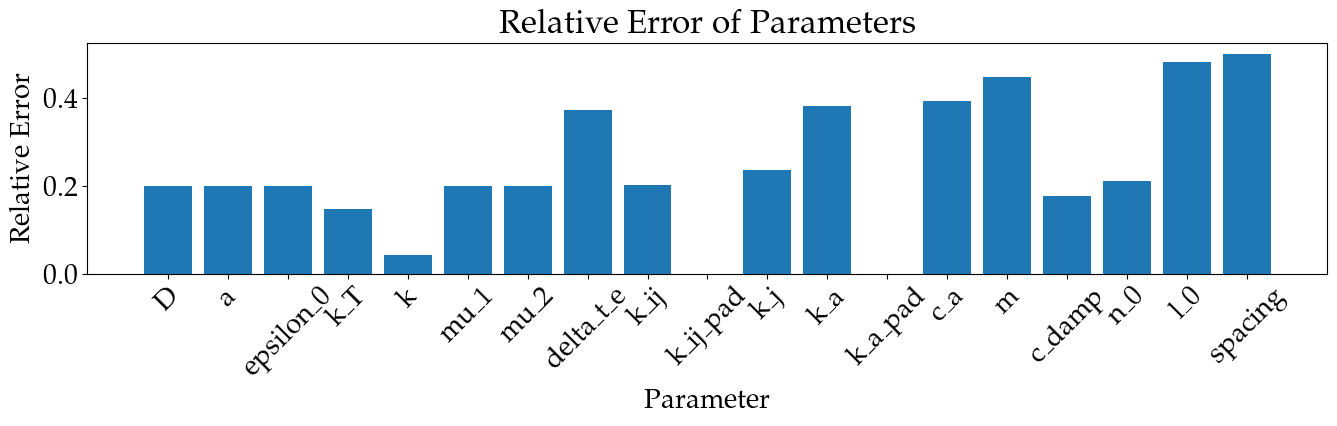

In [35]:
# Get the parameter names
param_names = list(params_true.keys())
# Calculate the relative error for each parameter
relative_errors = []

for param_name in param_names:
    
    real_value = params_true.get(param_name, np.nan)
    train_value = dataset_MSD.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [36]:
import numpy as np
import numpy as np
from scipy.ndimage import measurements
import numpy as np
from scipy.ndimage import sobel
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

def compute_laplacian_std_over_time(u):
    """
    Compute the Laplacian standard deviation (Laplacian STD) over time to measure wave curvature irregularities.
    
    Parameters:
        u (numpy.ndarray): Membrane voltage array of shape (time_steps, domain_x, domain_y).
    
    Returns:
        np.ndarray: Array of Laplacian standard deviations over time.
    """
    time_steps = u.shape[0]
    laplacian_std_values = []

    for t in range(time_steps):
        voltage_snapshot = u[t]  # Get voltage at time t

        # Compute Laplacian (measures curvature variations)
        laplacian_field = laplace(voltage_snapshot)

        # Compute and store Laplacian standard deviation
        laplacian_std = np.std(laplacian_field)
        laplacian_std_values.append(laplacian_std)

    return np.array(laplacian_std_values)

def compute_gradient_std_over_time(u):
    """
    Compute the gradient standard deviation (Gradient STD) over time to measure wave smoothness.
    
    Parameters:
        u (numpy.ndarray): Membrane voltage array of shape (time_steps, domain_x, domain_y).
    
    Returns:
        np.ndarray: Array of gradient standard deviations over time.
    """
    time_steps = u.shape[0]
    gradient_std_values = []

    for t in range(time_steps):
        voltage_snapshot = u[t]  # Get voltage at time t
        
        # Compute spatial gradients
        grad_x = sobel(voltage_snapshot, axis=0)
        grad_y = sobel(voltage_snapshot, axis=1)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Compute and store gradient standard deviation
        gradient_std = np.std(gradient_magnitude)
        gradient_std_values.append(gradient_std)

    return np.array(gradient_std_values)

def compute_spatial_wavelength(u, threshold_fraction=0.5, axis=0):
    """
    Estimate the spatial wavelength of the wave pattern.
    
    Parameters:
        u (numpy.ndarray): Membrane voltage array of shape (time_steps, domain_x, domain_y).
        threshold_fraction (float): Fraction of peak voltage used as threshold.
        axis (int): Spatial axis along which to measure wavelength (0 for x, 1 for y).
    
    Returns:
        float: Estimated mean spatial wavelength.
    """
    domain_x, domain_y = u.shape[1], u.shape[2]
    voltage_snapshot = u[-1]  # Use last time step for spatial analysis
    peak_voltage = np.max(voltage_snapshot)  # Find peak voltage
    threshold = threshold_fraction * peak_voltage  # Define threshold

    # Find wavefronts: Points where voltage is above the threshold
    wavefront_mask = voltage_snapshot > threshold

    # Compute labeled regions to detect separate wavefronts
    labeled, num_features = measurements.label(wavefront_mask)

    # Measure distances between consecutive wavefronts along the chosen axis
    wavelengths = []
    for i in range(domain_x if axis == 0 else domain_y):
        line = wavefront_mask[i, :] if axis == 0 else wavefront_mask[:, i]
        wavefront_positions = np.where(np.diff(line.astype(int)) == 1)[0]  # Detect edges
        
        if len(wavefront_positions) > 1:
            distances = np.diff(wavefront_positions)  # Compute distances between wavefronts
            wavelengths.extend(distances)

    # Compute mean spatial wavelength
    mean_wavelength = np.mean(wavelengths) if wavelengths else np.nan
    return mean_wavelength

def compute_mean_apd(u, threshold_fraction=0.5):
    """
    Compute the Mean Action Potential Duration (APD) for the given voltage time series.
    
    Parameters:
        u (numpy.ndarray): Membrane voltage array of shape (time_steps, domain_size, domain_size).
        threshold_fraction (float): Fraction of peak voltage used as APD threshold.
    
    Returns:
        float: Mean APD across the spatial domain.
    """
    time_steps, domain_x, domain_y = u.shape
    apd_list = []

    for i in range(domain_x):
        for j in range(domain_y):
            signal = u[:, i, j]  # Extract time series for one spatial point
            peak_voltage = np.max(signal)  # Maximum voltage at this point
            threshold = threshold_fraction * peak_voltage  # Define threshold

            # Find times when voltage crosses the threshold
            above_threshold = signal > threshold
            crossings = np.diff(above_threshold.astype(int))  # Detect threshold crossings

            upstroke_times = np.where(crossings == 1)[0]  # Upward crossings
            downstroke_times = np.where(crossings == -1)[0]  # Downward crossings

            # Match upstroke-downstroke pairs and compute APD
            for up in upstroke_times:
                down_candidates = downstroke_times[downstroke_times > up]
                if down_candidates.size > 0:
                    down = down_candidates[0]  # First downstroke after upstroke
                    apd_list.append(down - up)  # APD in time steps

    # Compute mean APD
    mean_apd = np.mean(apd_list) if apd_list else np.nan
    return mean_apd

u_pred = dataset_MSD.ys_sol['u'][0]
mean_apd = compute_mean_apd(u_pred)
mean_apd_BOCF = compute_mean_apd(u_BOCF[0],threshold_fraction=0.05)
mean_apd_AP = compute_mean_apd(u_AP[0])
print(f"Mean APD (AP Model): {mean_apd_AP:.2f} time steps")
print(f"Mean APD (BOCF Model): {mean_apd_BOCF:.2f} time steps")
print(f"Mean APD (Reconstruction): {mean_apd:.2f} time steps")

wavelength = compute_spatial_wavelength(u_pred)
wavelength_BOCF = compute_spatial_wavelength(u_BOCF[0])
wavelength_AP = compute_spatial_wavelength(u_AP[0])
print(f"Estimated spatial wavelength (AP Model): {wavelength:.2f} spatial units")
print(f"Estimated spatial wavelength (BOCF Model): {wavelength_BOCF:.2f} spatial units")
print(f"Estimated spatial wavelength (Reconstruction): {wavelength:.2f} spatial units")


gradient_std = compute_gradient_std_over_time(u_pred)
gradient_std_BOCF = compute_gradient_std_over_time(u_BOCF[0])
gradient_std_AP = compute_gradient_std_over_time(u_AP[0])
print(f"Gradient STD (AP Model): {np.mean(gradient_std_AP)}")
print(f"Gradient STD (BOCF Model): {np.mean(gradient_std_BOCF)}")
print(f"Gradient STD (Reconstruction): {np.mean(gradient_std)}")

laplacian_std = compute_laplacian_std_over_time(u_pred)
laplacian_std_BOCF = compute_laplacian_std_over_time(u_BOCF[0])
laplacian_std_AP = compute_laplacian_std_over_time(u_AP[0])
print(f"Laplacian STD (AP Model): {np.mean(laplacian_std_AP)}")
print(f"Laplacian STD (BOCF Model): {np.mean(laplacian_std_BOCF)}")
print(f"Laplacian STD (Reconstruction): {np.mean(laplacian_std)}")

Mean APD (AP Model): 5.18 time steps
Mean APD (BOCF Model): nan time steps
Mean APD (Reconstruction): 3.37 time steps
Estimated spatial wavelength (AP Model): 18.70 spatial units
Estimated spatial wavelength (BOCF Model): 53.71 spatial units
Estimated spatial wavelength (Reconstruction): 18.70 spatial units
Gradient STD (AP Model): 0.45770806074142456
Gradient STD (BOCF Model): 0.5646168967042203
Gradient STD (Reconstruction): 0.592879593372345
Laplacian STD (AP Model): 0.05194716900587082
Laplacian STD (BOCF Model): 0.13590995141933132
Laplacian STD (Reconstruction): 0.23648448288440704


/tmp/ipykernel_2386867/1325440240.py:84: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labeled, num_features = measurements.label(wavefront_mask)


In [ ]:
x = dataset_MSD.ys_sol['x'][0][pad:-pad,pad:-pad]
x_dot = dataset_MSD.ys_sol['x_dot'][0][pad:-pad,pad:-pad]
dA = compute_dA(x,1)[pad:-pad,pad:-pad]
dA_BOCF = compute_dA(x_BOCF[0],1)[pad:-pad,pad:-pad]
norm_x_dot = np.nanmean(np.linalg.norm(x_dot_BOCF,axis=1))
size_mech = domain_size + 2* 10 + 1
x_vals = np.linspace(0, size_mech-1,size_mech)
z_vals = np.linspace(0, size_mech-1,size_mech)
# Generate meshgrid for x and z
x_grid, z_grid = np.meshgrid(x_vals, z_vals)
xy_grid = jnp.array([x_grid, z_grid])
norm_x = np.nanmean(np.linalg.norm(x_BOCF[0]-xy_grid,axis=1))
norm_dA = np.nanmean(dA_BOCF)
print(dA.shape,x.shape)
print(norm_x_dot,norm_x,norm_dA)

(110, 128, 148) (130, 0, 149, 149)
0.04102190889762599 0.21962965 0.00020937865


In [ ]:
@jit
def time_distance_loss(y_true, y_pred, epsilon, max_time):
    """
    Computes the time it takes for y_pred to get within epsilon of y_true for a 2D grid of time series.

    Parameters:
    - y_true: (T, domain_size, domain_size) array of true values
    - y_pred: (T, domain_size, domain_size) array of predicted values
    - epsilon: float, threshold for closeness
    - max_time: int, maximum time step if not reached

    Returns:
    - loss: (T, domain_size, domain_size) array, tracking first match at each time step
    """
    T, domain_size, _ = y_pred.shape
    loss = jnp.full((int(T/3), domain_size, domain_size), max_time)  # Store loss for every time step

    for t_start in range(int(T/3),int(2*T/3)):
        errors = jnp.abs(y_pred - y_true[t_start])  # Compute errors for future time steps
        within_epsilon = errors < epsilon  # Boolean mask

        first_match = jnp.argmax(within_epsilon, axis=0)  # Get first time step where condition is met
        has_match = jnp.any(within_epsilon, axis=0)  # Check if a match exists

        # Assign first matching time step, otherwise keep max_time
        loss = loss.at[t_start].set(jnp.where(has_match, jnp.abs(first_match - t_start), max_time))

    return loss


In [ ]:

dA_true = (compute_dA(dataset_MSD.ys['x'][0],1)/np.max(dataset_MSD.ys['x'][0]))[:,pad:-pad,pad:-pad]

dA_pred = (compute_dA(dataset_MSD.ys_sol['x'][0],1)/np.max(dataset_MSD.ys_sol['x'][0]))[:,pad:-pad,pad:-pad]
y_true = dataset_MSD.ys['u'][0,:]/np.max(dataset_MSD.ys['u'][0,:])

y_pred = dataset_MSD.ys_sol['u'][0,:]/np.max(dataset_MSD.ys_sol['u'][0,:])
dA_err = np.abs(dA_true - dA_pred)

max_time = dA_true.shape[0]

epsilon = 0.00001
loss = time_distance_loss(dA_true, dA_pred, epsilon,max_time)

def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(loss[frame], cmap='coolwarm')
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"dA error")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=loss.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_single_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=32)

Output()